
* https://en.wikipedia.org/wiki/Bump_mapping
* https://web.archive.org/web/20060924191232/http://freespace.virgin.net/hugo.elias/graphics/x_polybm.htm

In [1]:
from PIL import Image as pil_image  # pillow probably?
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
xx, yy = np.meshgrid(np.arange(200), np.arange(200))

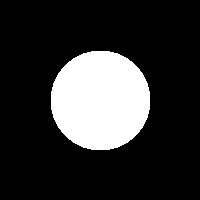

In [3]:
xcent, ycent, rad = 100, 100, 50
circle = ((xx - xcent)**2 + (yy - ycent)**2) < rad**2
pil_image.fromarray(circle)

## Bump/Depth Map

sphere:
$$x^2 + y^2 + z^2 = r^2 \\
z^2 = r^2 - x^2 - y^2 \\
$$

In [4]:
# select pixels in the sphere projection
# (already what the `circle` bool array is)

# for each, where x/y is given, compute z
zsq = rad**2 - (xx-xcent)**2 - (yy-ycent)**2
z = np.sqrt(np.clip(zsq, 0, None))

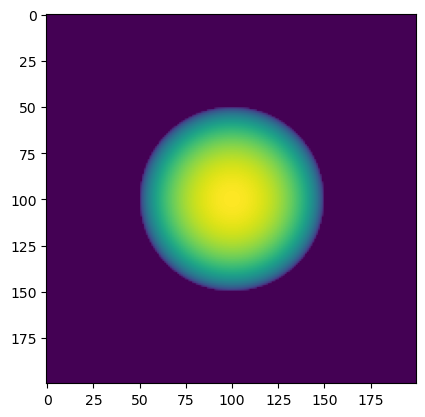

In [5]:
plt.imshow(z)

## (Hemi)sphere Normals

Can add some additional data into the map by defining the normal vector for each point. Assuming the depth map was 'smooth' and had no discontinuities, I think this would be equivalent, but additional information will be added into the normal map as you wind up with 2 independent variables per point. 

Building it from the ideal geometry, rather than differentating the depth map should give more ideal results. I think some of these assumptions are why the built-in "bump map" filter in GIMP can give crappy results

In [6]:
# then scale that to get the normal vector out from the center
xvec = (xx - xcent).astype('float64')
yvec = (yy - ycent).astype('float64')
zvec = z - 0
veclen = np.sqrt(xvec**2 + yvec**2 + zvec**2)
xvec /= veclen
yvec /= veclen
zvec /= veclen

xvec[z==0] = 0
yvec[z==0] = 0
zvec[z==0] = 1

normals = np.dstack((xvec, yvec, zvec))

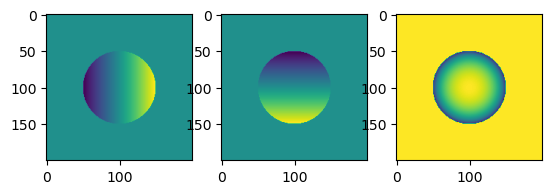

In [7]:
f, axs = plt.subplots(1, 3)
axs[0].imshow(xvec)
axs[1].imshow(yvec)
axs[2].imshow(zvec)

```
  X: -1 to +1 :  Red:     0 to 255
  Y: -1 to +1 :  Green:   0 to 255
  Z:  0 to -1 :  Blue:  128 to 255
```

In [8]:
min50max = [0, 50, 100]
np.percentile(xvec, min50max), np.percentile(yvec, min50max), np.percentile(zvec, min50max)

(array([-0.98,  0.  ,  0.98]),
 array([-0.98,  0.  ,  0.98]),
 array([0.02828427, 1.        , 1.        ]))

In [9]:
r = ((xvec + 1) * 255/2).astype("uint8")
g = ((yvec + 1) * 255/2).astype("uint8")
b = ((zvec + 1) * 255/2).astype("uint8")

np.percentile(r, min50max), np.percentile(g, min50max), np.percentile(b, min50max)

(array([  2., 127., 252.]),
 array([  2., 127., 252.]),
 array([131., 255., 255.]))

In [10]:
norm_colors = np.dstack((r, g, b))

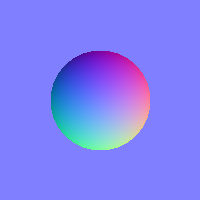

In [11]:
pil_image.fromarray(norm_colors)

Looks OK, but upside-down? Unsure if some of my coordinates are backwards or if I computed the normal map for the 'wrong' surface of the sphere

## Shading

* https://en.wikipedia.org/wiki/Phong_reflection_model

Phong is roughly: ambient + diffuse + specular. Ambient is constant if the surface is constant, i.e. there's no angle math or anything. Diffuse is for a fully matte object, and specular gives the shine.

$$ I_{\text{p}} \
=k_{\text{a}}i_{\text{a}} \
+\sum _{m\;\in \;{\text{lights}}}\
\left(\
  k_{\text{d}}({\hat L}_m\cdot {\hat N})i_{m,{\text{d}}}+\
  k_{\text{s}}({\hat R}_m\cdot {\hat V})^{\alpha }i_{m,{\text{s}}}\
\right)$$

* $k$: Reflection constants/ratio of reflection
    * $k_\text{a}$: Ambient
    * $k_\text{d}$: Diffuse
    * $k_\text{s}$: Specular
* $i$: Intensity (and color) of light(s).
* Diffuse terms
    * $\hat L_m$: Surface point to light $m$. For our purposes, the light will be infinitely far away, so this would be a constant.
    * $\hat N$: Normal. From the normal map.
* Specular terms
    * $\hat R_m$: The reflection of $\hat L_m$ off the surface. Can be computed as below.
    * $\hat V$: Surface to viewer. For us, again, constant. Straight up.
    * $\alpha$: "Shinyness" exponent. If this is large, it will increase how 'picky' the specular light rays are because they'll need to align more closely with the ideal reflection angle. Larger exponents will force any unit vector dot products (all <1) that are only close to 1 to be very-not-1. i.e. 

$$
{\hat R}_m = 2({\hat L}_m \cdot \hat N)\hat N - {\hat L}_m
$$

The "for our purposes" simplifications is actually what *Blinn-Phong* is, where the viewer and light are at infinity. Our performance isn't really a concern though, and I can't find the equations for it to implement...

In [12]:
# light stuff
l_angle_vert_deg = 45
l_angle_horiz_deg = 45

l_x = np.cos(np.deg2rad(l_angle_horiz_deg)) 
l_y = np.sin(np.deg2rad(l_angle_horiz_deg))
l_z = np.tan(np.deg2rad(l_angle_vert_deg))
l_vec = np.array([l_x, l_y, l_z])
l_vec /= np.linalg.norm(l_vec)
l_vec

array([0.5       , 0.5       , 0.70710678])

In [13]:
l_vec

array([0.5       , 0.5       , 0.70710678])

In [14]:
diffuse = np.tensordot(l_vec, normals, axes=(0, 2))
reflect = 2 * np.expand_dims(diffuse, axis=-1) * normals - l_vec
diffuse = diffuse.clip(0, None) # or else the 'back' will also be lit

# mask
diffuse[z==0] = 0
reflect[z==0] = np.array([0, 0, 0])

diffuse.shape, reflect.shape

((200, 200), (200, 200, 3))

In [15]:
v_vec = np.array([0, 0, 1])  # from above
specular_pre = np.tensordot(reflect, v_vec, axes=(2, 0))
specular_pre = specular_pre.clip(0, None) # or else the 'back' will also be shiny
specular_pre.shape

(200, 200)

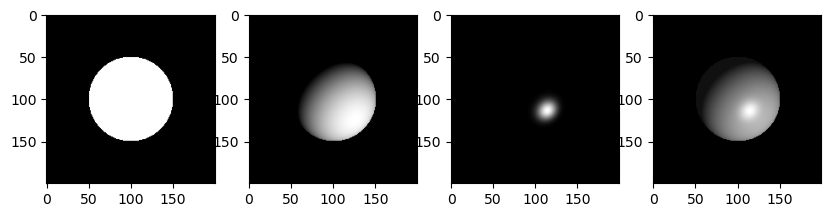

In [16]:
k_ambient = 0.2
k_diffuse = 2
k_specular = 1
specular_alpha = 10

ambient = (z!=0).astype('float64')
specular = specular_pre ** specular_alpha

image = k_ambient * ambient + k_diffuse * diffuse + k_specular * specular

f, axs = plt.subplots(1, 4)
f.set_size_inches(10, 3)
axs[0].imshow(ambient, cmap="binary_r")
axs[1].imshow(diffuse, cmap="binary_r")
axs[2].imshow(specular, cmap="binary_r")
axs[3].imshow(image, cmap="binary_r")

...as an aside, refreshing myself on how to do the math. Not sure how to multiply out the 2-D greyscale to an RGB image.

In [17]:
x = np.array([
    [1.0, 0.0,],# 0.0, 0.0],
    [0.5, 1.0,],# 0.0, 0.1],
    #[1.0, 0.0, 0.3, 0.4],
    #[0.9, 0.8, 0.7, 0.6],
])
green = np.array(colors.to_rgb(colors.XKCD_COLORS["xkcd:green"]))
green, x

(array([0.08235294, 0.69019608, 0.10196078]),
 array([[1. , 0. ],
        [0.5, 1. ]]))

In [18]:
x.shape, green.shape  # to dot-product/multiply them, shove in a sham dimension on either side:

((2, 2), (3,))

In [19]:
greenx = np.expand_dims(green, 0)
greenx.shape
(np.expand_dims(x, -1) @ greenx).shape

(2, 2, 3)

OK, got it...

In [20]:
def color_array(img, color):
    if isinstance(color, str):
        hex_color = colors.get_named_colors_mapping()[color]
        color = colors.to_rgb(hex_color)
        color = np.array(color)
    color = np.expand_dims(color, 0)
    assert color.shape == (1, 3)
        
    if img.ndim == 3 and img.shape[-1] != 1:
        raise ValueError("img expected to be 2-D or 3-D with final dimension size 1", img.shape)
    elif img.ndim != 2:
        raise ValueError("img expected to be 2-D or 3-D with final dimension size 1", img.shape)
    else:
        img = np.expand_dims(img, -1)
    assert img.ndim == 3
    assert img.shape[-1] == 1
    
    return img @ color

color_array(x, "xkcd:green")

array([[[0.08235294, 0.69019608, 0.10196078],
        [0.        , 0.        , 0.        ]],

       [[0.04117647, 0.34509804, 0.05098039],
        [0.08235294, 0.69019608, 0.10196078]]])

In [21]:
def img_float_to_byte(array, rescale=1):
    """
    *rescale* is kinda like an exposure setting. Default of 1 will be scaled with 
    brightest point hitting 255 (in a single channel), but can 'overexpose' by bumping
    it up.
    """
    if array.ndim != 3:
        raise ValueError("expecting 3D array with dims x, y, color", array.shape)
    if array.shape[-1] != 3:
        raise ValueError("expecting 3D array with dims x, y, color", array.shape)
        
    scaled = array * 255 / np.max(array)
    rescaled = np.clip(scaled * rescale, 0, 255)
        
    return rescaled.astype('uint8')

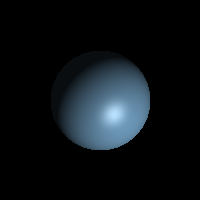

In [22]:
img = (
    k_ambient  * color_array(ambient,  "xkcd:light blue") +
    k_diffuse  * color_array(diffuse,  "xkcd:light blue") +
    k_specular * color_array(specular, "xkcd:white")
)
pil_image.fromarray(img_float_to_byte(img, 1))

In [23]:
a = np.array([True, False]).astype("float64")
sorted(np.unique(a)) == [0, 1]

True

In [24]:
def altazi_to_cart(altitude, azimuth, distance=1, mode="deg"):
    """
    Convert the altitude (angle above horizon) and azimuth (angle around the horizon)
    to cartesian XYZ coordinates. Leave *distance* as 1 for a unit vector.
    
    This is similar to spherical to cartesian, but altitude is angle up from the plane,
    while in spherical coordinates it's the angle down from the central axis.
    """
    if mode == "deg":
        altitude = np.deg2rad(altitude)
        azimuth = np.deg2rad(azimuth)
    x = np.cos(azimuth) * np.cos(altitude)
    y = np.sin(azimuth) * np.cos(altitude)
    z = np.sin(altitude)
    return distance * np.array([x, y, z])

assert np.allclose(altazi_to_cart(90, 0), np.array([0, 0, 1]))
assert np.allclose(altazi_to_cart(90, 1234567), np.array([0, 0, 1]))
assert np.allclose(altazi_to_cart(0, 0), np.array([1, 0, 0]))
assert np.allclose(altazi_to_cart(0, 90), np.array([0, 1, 0]))
assert np.allclose(altazi_to_cart(0, 45), np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0]))

In [25]:
import abc

class Light(metaclass=abc.ABCMeta):
#     def __init__(self, intensity, color):
#         self.intensity = intensity

#         if isinstance(color, str):
#             hex_color = colors.get_named_colors_mapping()[color]
#             color = colors.to_rgb(hex_color)
#         color = np.array(color)
#         if color.shape != (3,):
#             raise ValueError("color_rgb must be a 1D, 3-element array (RGB)", color.shape)
#         self._color = color

    def _repr_props(self) -> list[tuple[str, str]]:
        return [("intensity", repr(self.intensity)), ("color", repr(self._color))]
    
    def __repr__(self):
        props = ", ".join(f"{name}={val}" for name, val in self._repr_props())
        return f"{self.__class__.__name__}({props})"
    
    @abc.abstractmethod
    def compute(self, normals):
        """
        *normals* is an [x, y, 3] array of normal vectors, where the final dimension is
        an XYZ unit vector.
                
        Returns a [x, y, 3] image, where the final dimension is an RGB triplet.
        """


class AmbientLight(Light):
    # just for the __name__
    
    def compute(self, normals):
        return np.ones(normals.shape[:-1], dtype="float64")
        

class DirectionalLight(Light):
    def __init__(self, direction):
        super().__init__()
        
        direction = np.array(direction)
        if direction.shape != (3,):
            # what direction is which way is really poorly tracked..."at the light" might be backwards. meh.
            raise ValueError("direction must be a 1D, 3-element array; a vector pointing at the light", direction.shape)
        direction = direction / np.linalg.norm(direction)  # unitize
        self._direction = direction

    def _repr_props(self) -> list[tuple[str, str]]:
        return super()._repr_props() + [("direction", self._direction)]


class DiffuseLight(DirectionalLight):
    def compute(self, normals):
        diffuse = np.tensordot(self._direction, normals, axes=(0, 2))
        return diffuse.clip(0, None)

        
class SpecularLight(DirectionalLight):
    def __init__(self, direction, alpha=10):
        self.alpha = alpha
        super().__init__(direction)

    def compute(self, normals):
        diffuse = np.tensordot(self._direction, normals, axes=(0, 2))
        reflect = 2 * np.expand_dims(diffuse, axis=-1) * normals - self._direction
        v_vec = np.array([0, 0, 1])  # always viewing from above
        specular_pre = np.tensordot(reflect, v_vec, axes=(2, 0))
        specular_pre = specular_pre.clip(0, None) # or else the 'back' will also be shiny
        return specular_pre ** self.alpha

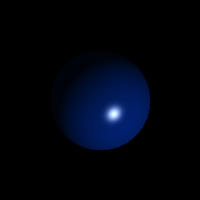

In [26]:
lights = [
    ("xkcd:blue", 0.1, AmbientLight()),
    ("xkcd:blue", 1.0, DiffuseLight(altazi_to_cart(45, 45))),
    ("xkcd:white", 2.0, SpecularLight(altazi_to_cart(45, 45), alpha=30)),
]

def flat_phong(normals, lights, mask=None):
    layers = [
        intensity * color_array(light.compute(normals), color)
        for (color, intensity, light) in lights
    ]
    img = np.sum(layers, axis=0)
    if mask is not None:
        img[~mask] = [0, 0, 0]
    return img

pil_image.fromarray(img_float_to_byte(flat_phong(normals, lights, z!=0), rescale=1.3))

Does it look better if a different colorspace is used? Perceptually, if monochromatic lights get brighter, they should tend towards white, e.g. lightsabers.

Not sure what to pick though. Anyways, can probably skip this for our purposes?

# Beveling and shading

In [27]:
dpi = 600
mtg_circle = 153  # at 600 dpi
edge_curves = 163
bar_width = 100
bevel_width = 15

oversample = 4

raised_img = np.zeros([200 * oversample, 300 * oversample], dtype="float64")

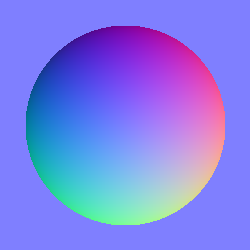

In [28]:
def show_normal_map(normals):
    """
    Convert a normal map with floating point unit vectors to an 8-bit/channel RGB image
    """
    return pil_image.fromarray(((normals + 1) * 255/2).astype("uint8"))

def draw_sphere(dims, center, radius):
    xx, yy = np.meshgrid(np.arange(dims[0]), np.arange(dims[1]))
    
    xcent, ycent = center
    circle = ((xx - xcent)**2 + (yy - ycent)**2) < radius**2

    # select pixels in the sphere projection
    # (already what the `circle` bool array is)

    # for each, where x/y is given, compute z
    zsq = radius**2 - (xx-xcent)**2 - (yy-ycent)**2
    z = np.sqrt(np.clip(zsq, 0, None))

    # then scale that to get the normal vector out from the center
    xvec = (xx - xcent).astype('float64')
    yvec = (yy - ycent).astype('float64')
    zvec = z - 0
    veclen = np.sqrt(xvec**2 + yvec**2 + zvec**2)
    xvec /= veclen
    yvec /= veclen
    zvec /= veclen

    xvec[z==0] = 0
    yvec[z==0] = 0
    zvec[z==0] = 1

    normals = np.dstack((xvec, yvec, zvec))
    return normals

show_normal_map(draw_sphere((250, 250), (125, 125), 100))

In [29]:
dims = 300, 200
center = 100, 100
radius = 80
height = 80
#def draw_cone(dims, center, radius, height):

xx, yy = np.meshgrid(np.arange(dims[0]), np.arange(dims[1]))
xcent, ycent = center

# normal x/y will always point away from center, but blend with z will depend on 
# the difference between the radius and height (i.e. 45deg if they're equal)

# lets ignore z and just compute x/y to point out (this would be shaded like 
# a cylinder, strangely.)
x = xx - xcent
y = yy - ycent

flat = np.dstack([x, y])
# normalize
norm_scale = np.linalg.norm(flat, axis=2)
norm_scale[norm_scale==0] = 1  # avoid div-by-zero error
flat = flat / np.expand_dims(norm_scale, -1)

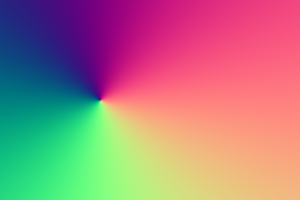

In [30]:
# currently just x/y, pad with z=0 for illustration
show_normal_map(np.pad(flat, [(0, 0), (0, 0), (0, 1)]))

In [31]:
# next, collapse the infinitely-high cone (cylinder) to something finite
# by reducing all the x/y vectors so the XY length / Z length = radius / height

# Z vectors will all be constant, so that's easy. 
#
#    xy / z  = radius / height
#    z  / xy = height / radius
#
# We already scaled the XYs (horizontals) to length 1, so:
#
#    z       = height / radius
coneized = np.pad(flat, [(0, 0), (0, 0), (0, 1)], constant_values=height/radius)
coneized.shape

(200, 300, 3)

In [32]:
# can redo the `np.linalg.norm` thing to unitize them all, 
# but XY is 1, Z is whatever...just scale them all by a scalar.
coneized = coneized / np.sqrt((height/radius)**2 + 1)
np.unique(np.linalg.norm(coneized, axis=2), return_counts=True)

(array([0.70710678, 1.        , 1.        , 1.        ]),
 array([    1,  3041, 54991,  1967], dtype=int64))

In [33]:
# the center is wrong tho...
coneized[xcent, ycent]

array([0.        , 0.        , 0.70710678])

In [34]:
# spot fix...
coneized[xcent, ycent] = [0, 0, 1]
np.unique(np.linalg.norm(coneized, axis=2), return_counts=True)

(array([1., 1., 1.]), array([ 3041, 54991,  1968], dtype=int64))

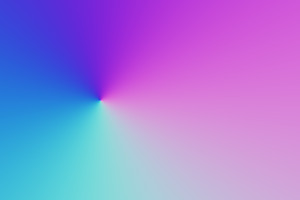

In [35]:
show_normal_map(coneized)

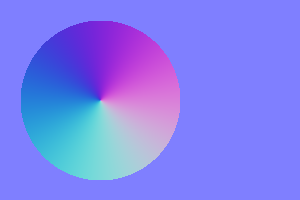

In [36]:
# just need to mask it out
circle = ((xx - xcent)**2 + (yy - ycent)**2) < radius**2
coneized[~circle] = [0, 0, 1]
show_normal_map(coneized)

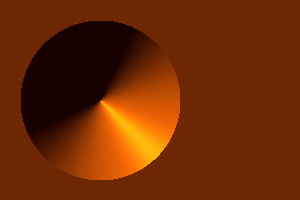

In [37]:
pil_image.fromarray(img_float_to_byte(flat_phong(coneized, [
    ("xkcd:red", 0.1, AmbientLight()),
    ("xkcd:orange", 1.0, DiffuseLight(altazi_to_cart(20, 45))),
    ("xkcd:yellow", 2.0, SpecularLight(altazi_to_cart(20, 45), alpha=30)),
]), rescale=1.3))

In [38]:
x, y = 3, 4
xx, yy = np.meshgrid(np.arange(y), np.arange(x))
xx.shape

(3, 4)

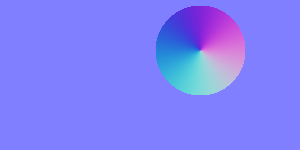

In [39]:
def draw_cone_rev1(dims, center, radius, height):
    # this version copied from the manual steps above
    xx, yy = np.meshgrid(np.arange(dims[0]), np.arange(dims[1]))
    xcent, ycent = center

    # normal x/y will always point away from center, but blend with z will depend on 
    # the difference between the radius and height (i.e. 45deg if they're equal)

    # lets ignore z and just compute x/y to point out (this would be shaded like 
    # a cylinder, strangely.)
    x = xx - xcent
    y = yy - ycent

    flat = np.dstack([x, y])
    # normalize
    norm_scale = np.linalg.norm(flat, axis=2)
    norm_scale[norm_scale==0] = 1  # avoid div-by-zero error
    flat = flat / np.expand_dims(norm_scale, -1)

    coneized = np.pad(flat, [(0, 0), (0, 0), (0, 1)], constant_values=height/radius)
    coneized = coneized / np.sqrt((height/radius)**2 + 1)
    
    # fix center point (incorrectly scaled)
    coneized[ycent, xcent] = [0, 0, 1]  # coords seem backwards...very confusing

    # mask
    circle = ((xx - xcent)**2 + (yy - ycent)**2) < radius**2
    coneized[~circle] = [0, 0, 1]
    
    return coneized

def draw_cone(dims, center, radius, height):
    # this shortcuts the z-dimension
    xx, yy = np.meshgrid(np.arange(dims[0]), np.arange(dims[1]))
    xcent, ycent = center

    x = xx - xcent
    y = yy - ycent
    
    dist_sq = (x**2 + y**2)
    z = np.sqrt(dist_sq) * (height / radius)

    # mask
    circle = dist_sq < radius**2
    x[~circle] = y[~circle] = 0
    
    # avoid div/zero error
    x[ycent, xcent] = y[ycent, xcent] = 0
    z[ycent, xcent] = 1
    
    normals = np.dstack([x, y, z])
    norm_scale = np.linalg.norm(normals, axis=2)
    normals = normals / np.expand_dims(norm_scale, -1)
    
    return normals

show_normal_map(draw_cone((300, 150), (200, 50), 45, 45))